# Exploring the Impact of Mini-Halos

In [17]:
import matplotlib
import numpy as np
import attrs

import matplotlib.pyplot as plt

import py21cmfast as p21c
from tempfile import mkdtemp

## Basic Setup

Let's fix the initial condition for this tutorial.

In [3]:
output_dir = "cache"
cache = p21c.OutputCache(output_dir)

In [5]:
# USE_FFTW_WISDOM makes the FFT faster
inputs = p21c.InputParameters.from_template(
    'Qin20', HII_DIM=128, LOWRES_CELL_SIZE_MPC=2.0, HIRES_TO_LOWRES_FACTOR=2, USE_FFTW_WISDOM=True, N_THREADS=4, USE_RELATIVE_VELOCITIES=True, random_seed=1993
)
initial_conditions = p21c.compute_initial_conditions(
    inputs=inputs, cache=cache, write=True
)output_dir

## Fiducial Lightcone

Let's run a 'fiducial' model and see its lightcones

Note that the reference model has 

    pow(10, "F_STAR7_MINI") = pow(10, "F_STAR10") / pow(1000,ALPHA_STAR) * 10 # 10 times enhancement
    pow(10, "F_ESC7_MINI" ) = pow(10, "F_ESC10" ) / pow(1000,ALPHA_ESC ) / 10 # 0.1 times enhancement to balance the 10 times enhanced Ngamma
    pow(10, "L_X_MINI"    ) = pow(10, "L_X")
    1 - "F_H2_SHIELD"  = 1

In [9]:
# the lightcones we want to plot later together with their color maps and min/max
lightcone_quantities = (
    "brightness_temp",
    "spin_temperature",
    "neutral_fraction",
    "cumulative_recombinations",
    "z_reion",
    "ionisation_rate_G12",
    "J_21_LW",
    "density",
)

global_quantities = (
    "brightness_temp",
    "spin_temperature",
    "neutral_fraction",
    "cumulative_recombinations",
    "z_reion",
    "ionisation_rate_G12",
    "density",
)

lcn = p21c.RectilinearLightconer.between_redshifts(
    min_redshift=min(inputs.node_redshifts)+0.1,
    max_redshift=max(inputs.node_redshifts)-0.1,
    quantities=lightcone_quantities,
    resolution=inputs.simulation_options.cell_size,
)

# This takes about 40 minutes.
lightcone_fid = p21c.run_lightcone(
    lightconer=lcn,
    inputs=inputs,
    initial_conditions=initial_conditions,
    cache=cache,
    write=True,
    progressbar=True
)

lightcone_fid.save(cache.direc / "mini-halo-fiducial-lightcone.h5")

Output()

Output()

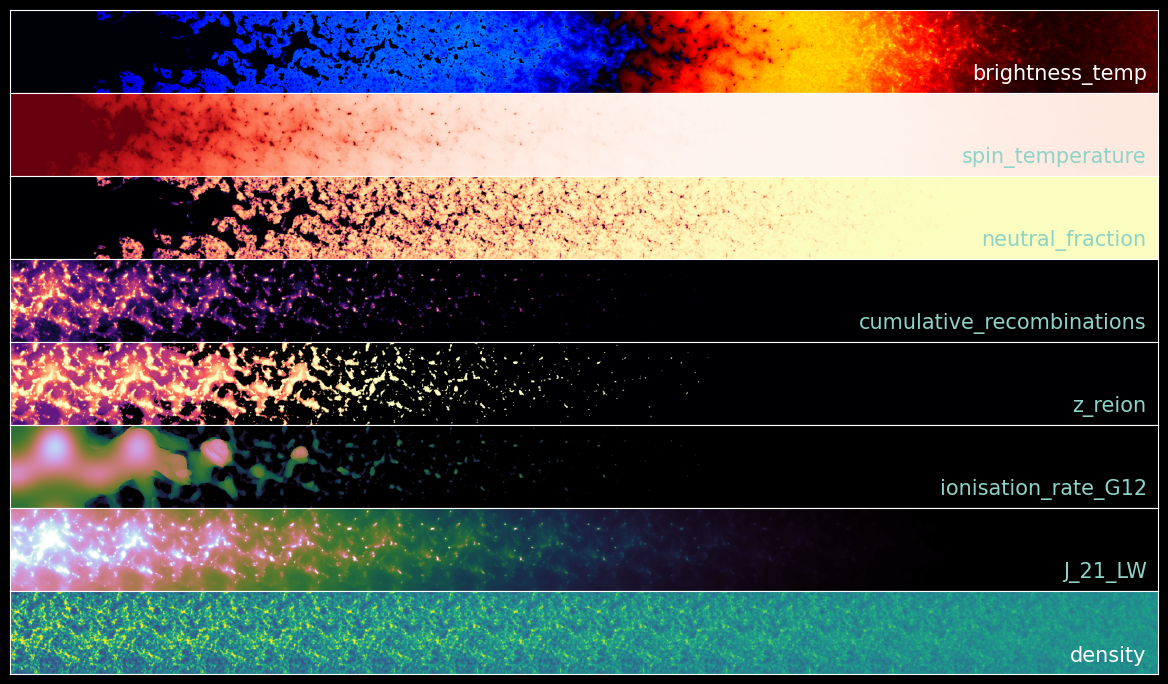

In [10]:
plt.style.use("dark_background")
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list(
    "mycmap",
    [
        (0, "white"),
        (0.33, "yellow"),
        (0.5, "orange"),
        (0.68, "red"),
        (0.83333, "black"),
        (0.9, "blue"),
        (1, "cyan"),
    ],
)

cmaps = [
    EoR_colour,
    "Reds",
    "magma",
    "magma",
    "magma",
    "cubehelix",
    "cubehelix",
    "viridis",
]
vmins = [-150, 1e1, 0, 0, 5, 0, 0, -1]
vmaxs = [30, 1e3, 1, 2, 9, 1, 10, 1]

bt = lightcone_fid.lightcones['brightness_temp']

fig, axs = plt.subplots(
    len(lightcone_quantities),
    1,
    figsize=(
        12,
        12 * (bt.shape[0]/bt.shape[2]) * len(lightcone_quantities),
    ),
    sharex=True,
    sharey=True,
    layout='tight',
    gridspec_kw={"hspace": 0, "wspace": 0}
)
for ii, lightcone_quantity in enumerate(lightcone_quantities):
    axs[ii].imshow(
        lightcone_fid.lightcones[lightcone_quantity][1],
        vmin=vmins[ii],
        vmax=vmaxs[ii],
        cmap=cmaps[ii],
    )
    t = axs[ii].text(
        0.99,
        0.1,
        lightcone_quantity,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=axs[ii].transAxes,
        color="w" if lightcone_quantity in ['brightness_temp', 'density'] else 'C0',
        #backgroundcolor="white",
        fontsize=15,
    )
#    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])


## Varying Parameters

Let's vary paremeters that describe mini-halos and see the impact on the global signal.

We keep other parameters fixed and vary one of following  by a factor of 0.1, 0.5, 2 and 10:

    pow(10, "F_STAR7_MINI")
    pow(10, "F_ESC7_MINI")
    pow(10, "L_X_MINI")
    1 - "F_H2_SHIELD"
    
We also have a NO-mini model where mini-halos are not included

In [11]:
# defining those color, linstyle, b
linestyles = ["-", "-", ":", "-.", "-.", ":"]
colors = ["gray", "black", "#e41a1c", "#377eb8", "#e41a1c", "#377eb8"]
lws = [1, 3, 2, 2, 2, 2]

texts = [
    "varying " + r"$f_{*,7}^{\rm mol}$",
    "varying " + r"$f_{\rm esc}^{\rm mol}$",
    "varying " + r"$L_{\rm x}^{\rm mol}$",
    "varying " + r"$1-f_{\rm H_2}^{\rm shield}$",
]
var_params = ["F_STAR7_MINI","F_ESC7_MINI","L_X_MINI","F_H2_SHIELD"]
factors = [0, 1, 0.1, 0.5, 2, 10]
labels = ["NO-mini", "reference", "x0.1", "x0.5", "x2", "x10"]

Note that I've run these simulations in parallel before this tutorial. With these setup, each took ~6h to finish. Here, running means read the cached outputs.

In [18]:
all_lightcones = {}

for pp, text in enumerate(texts):
    all_lightcones[text] = {}
    for kk, label in enumerate(labels):
        print(text, label)
        
        factor = factors[kk]

        if label!='NO-mini':
            gq = global_quantities + ("J_21_LW",)
            _lcn = lcn
        else:
            gq = global_quantities
            _lcn = attrs.evolve(lcn, quantities=[q for q in lcn.quantities if q != 'J_21_LW'])
            
        if var_params[pp] == "F_H2_SHIELD":
            if factor > 1:
                continue
                
            inputs_var = inputs.evolve_input_structs(
                USE_MINI_HALOS=(label!="NO-mini"),
                F_H2_SHIELD=1. - (1. - inputs.astro_params.F_H2_SHIELD)*factor,
            )
        else:
            inputs_var = inputs.evolve_input_structs(
                USE_MINI_HALOS=(label!="NO-mini"),
                **{var_params[pp] : getattr(inputs.astro_params, var_params[pp]) * factor}
            )
            
        if label == "reference":
            lightcone = lightcone_fid
        else:
            lightcone = p21c.run_lightcone(
                lightconer=_lcn,
                initial_conditions=initial_conditions,
                inputs=inputs_var,
                global_quantities=gq,
                cache=cache,
                write=True,
                progressbar=True
            )
            
        all_lightcones[text][label] = lightcone

Evolving Astrophysics ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━  30% • 26/88 redshifts • 0:05:41 • 0:23:17 remaining

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evolving Astrophysics ━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━  60% • 53/88 redshifts • 0:19:11 • 0:17:27 remaining

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Global Averages

In [27]:
all_lightcones.keys()

dict_keys(['varying $f_{*,7}^{\\rm mol}$', 'varying $f_{\\rm esc}^{\\rm mol}$', 'varying $L_{\\rm x}^{\\rm mol}$'])

In [28]:
lightcone_fid.global_quantities.keys()

dict_keys(['brightness_temp', 'neutral_fraction'])

In [26]:

# choose some to plot...
plot_quantities = (
    "brightness_temp",
    "spin_temperature",
    "neutral_fraction",
    "cumulative_recombinations",
    "ionisation_rate_G12",
    "J_21_LW",
)
ymins = [-120, 1e1, 0, 0, 0, 0]
ymaxs = [30, 1e3, 1, 1, 1, 10]

fig, axss = plt.subplots(
    len(plot_quantities),
    len(labels),
    sharex=True,
    figsize=(4 * len(labels), 2 * len(global_quantities)),
)

for pp, text in enumerate(texts):
    axs = axss[:, pp]
    for kk, label in enumerate(labels):
        factor = factors[kk]

        lightcone = all_lightcones[text][label]

        freqs = 1420.4 / (np.array(lightcone.inputs.node_redshifts) + 1.0)
        for jj, global_quantity in enumerate(plot_quantities):
            if global_quantity in lightcone.global_quantities:
                axs[jj].plot(
                    freqs,
                    lightcone.global_quantities[global_quantity],
                    color=colors[kk],
                    linestyle=linestyles[kk],
                    label=labels[kk],
                    lw=lws[kk],
                )
            else:
                print(global_quantity)
    axs[0].text(
        0.01,
        0.99,
        texts,
        horizontalalignment="left",
        verticalalignment="top",
        transform=axs[0].transAxes,
        fontsize=15,
    )
    for jj, global_quantity in enumerate(plot_quantities):
        axs[jj].set_ylim(ymins[jj], ymaxs[jj])
    axs[-1].set_xlabel("Frequency/MHz", fontsize=15)
    axs[-1].xaxis.set_tick_params(labelsize=15)

    axs[0].set_xlim(1420.4 / (35 + 1.0), 1420.4 / (5.5 + 1.0))
    zlabels = np.array([6, 7, 8, 10, 13, 18, 25, 35])
    ax2 = axs[0].twiny()
    ax2.set_xlim(axs[0].get_xlim())
    ax2.set_xticks(1420.4 / (zlabels + 1.0))
    ax2.set_xticklabels(zlabels.astype(str))
    ax2.set_xlabel("redshift", fontsize=15)
    ax2.xaxis.set_tick_params(labelsize=15)
    ax2.grid(False)

    if pp == 0:
        axs[0].legend(
            loc="lower right", ncol=2, fontsize=13, fancybox=True, frameon=True
        )
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].set_ylabel(
                "global_{}".format(global_quantity.replace("_box", "")), fontsize=15
            )
            axs[jj].yaxis.set_tick_params(labelsize=15)
    else:
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].set_ylabel(
                "global_{}".format(global_quantity.replace("_box", "")), fontsize=0
            )
            axs[jj].yaxis.set_tick_params(labelsize=0)

plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

J_21_LW
spin_temperature
cumulative_recombinations
ionisation_rate_G12
J_21_LW
J_21_LW
spin_temperature
cumulative_recombinations
ionisation_rate_G12
J_21_LW


KeyError: 'NO-mini'

Error in callback <function _draw_all_if_interactive at 0x7f694b6efd80> (for post_execute):


ValueError: 
f_{*,7}^{\\rm mol}
         ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\'  (at char 9), (line:1, col:10)

ValueError: 
f_{*,7}^{\\rm mol}
         ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\'  (at char 9), (line:1, col:10)

<Figure size 2400x1400 with 38 Axes>

### 21-cm power spectra

In [87]:
# define functions to calculate PS, following py21cmmc
from powerbox.tools import get_power


def compute_power(
    box,
    length,
    n_psbins,
    log_bins=True,
    ignore_kperp_zero=True,
    ignore_kpar_zero=False,
    ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, dtype=int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res


def powerspectra(
    brightness_temp, n_psbins=50, nchunks=10, min_k=0.1, max_k=1.0, logk=True
):
    data = []
    chunk_indices = list(
        range(
            0,
            brightness_temp.n_slices,
            round(brightness_temp.n_slices / nchunks),
        )
    )

    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k**3 / (2 * np.pi**2)})
    return data

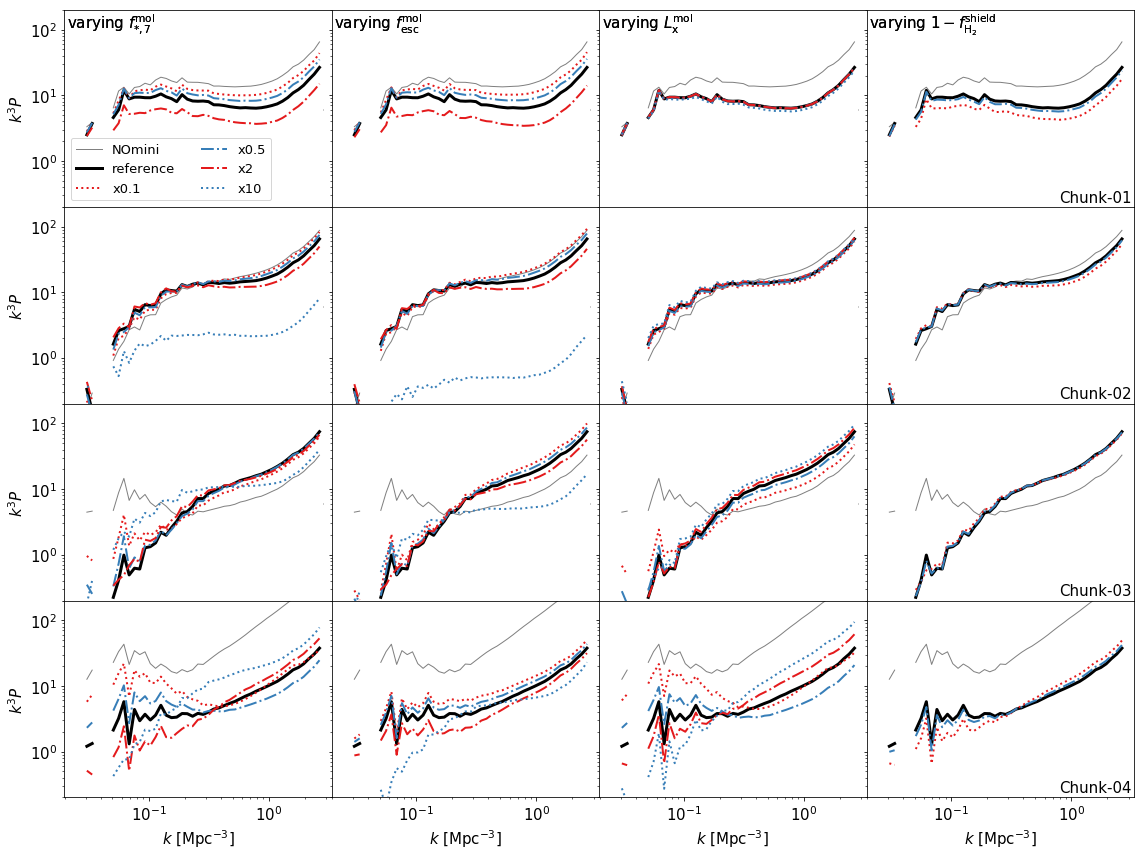

In [ ]:
# do 5 chunks but only plot 1 - 4, the 0th has no power for minihalo models where xH=0
nchunks = 4

fig, axss = plt.subplots(
    nchunks,
    len(labelss),
    sharex=True,
    sharey=True,
    figsize=(4 * len(labelss), 3 * (nchunks)),
    subplot_kw={"xscale": "log", "yscale": "log"},
)

for pp, text in enumerate(texts):
    labels = labels[pp]
    factors = factors[pp]
    axs = axss[:, pp]
    for kk, label in enumerate(labels):
        factor = factors[kk]

        if var_params[pp] == "F_H2_SHIELD":
            if factor > 1:
                continue
            inputs_var = inputs.evolve_input_structs(
                USE_MINI_HALOS=(label!="NOmini"),
                F_H2_SHIELD=1. - (1. - inputs.astro_params.F_H2_SHIELD)*factor,
            )
        else:
            inputs_var = inputs.evolve_input_structs(
                USE_MINI_HALOS=(label!="NOmini"),
                **{var_params[pp] : inputs.astro_params.get(var_params[pp]) * factor}
            )
        if label == "reference":
            lightcone = lightcone_fid
        else:
            lightcone = p21c.run_lightcone(
                initial_conditions=initial_conditions,
                inputs=inputs_var,
                direc=cache,
            )

        PS = powerspectra(lightcone)
        for ii in range(nchunks):
            axs[ii].plot(
                PS[ii + 1]["k"],
                PS[ii + 1]["delta"],
                color=colors[kk],
                linestyle=linestyles[kk],
                label=labels[kk],
                lw=lws[kk],
            )

            if pp == len(texts) - 1 and kk == 0:
                axs[ii].text(
                    0.99,
                    0.01,
                    "Chunk-%02d" % (ii + 1),
                    horizontalalignment="right",
                    verticalalignment="bottom",
                    transform=axs[ii].transAxes,
                    fontsize=15,
                )

    axs[0].text(
        0.01,
        0.99,
        texts,
        horizontalalignment="left",
        verticalalignment="top",
        transform=axs[0].transAxes,
        fontsize=15,
    )

    axs[-1].set_xlabel("$k$ [Mpc$^{-3}$]", fontsize=15)
    axs[-1].xaxis.set_tick_params(labelsize=15)

    if pp == 0:
        for ii in range(nchunks):
            axs[ii].set_ylim(2e-1, 2e2)
            axs[ii].set_ylabel("$k^3 P$", fontsize=15)
            axs[ii].yaxis.set_tick_params(labelsize=15)
    else:
        for ii in range(nchunks - 1):
            axs[ii].set_ylim(2e-1, 2e2)
            axs[ii].set_ylabel("$k^3 P$", fontsize=0)
            axs[ii].yaxis.set_tick_params(labelsize=0)

axss[0, 0].legend(loc="lower left", ncol=2, fontsize=13, fancybox=True, frameon=True)
plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

 Now you know how minihalo can shape the 21-cm signal!